In [1]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

! pip install googlemaps
! pip install xlrd

import io
import os
from google.colab import files
from google.colab import drive
import pandas as pd
import folium
import numpy as np
import googlemaps
import math
import warnings
warnings.filterwarnings(action='ignore')

  Created wheel for googlemaps: filename=googlemaps-4.5.3-py3-none-any.whl size=38479 sha256=4e9d37fd1db9f762a2e3a13b68c6858d9a8a145e50b5dabeff64a4f33625a97e
  Stored in directory: /root/.cache/pip/wheels/fa/1a/1c/cc0b8a1652a3f06aea586b0e4714a81bafed830513969baf92
Successfully built googlemaps


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train_df = pd.read_csv('/content/gdrive/MyDrive/JobCare/Jobcare_data/train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/JobCare/Jobcare_data/test.csv')

d_code = pd.read_csv('/content/gdrive/MyDrive/JobCare/Jobcare_data/속성_D_코드.csv')
h_code = pd.read_csv('/content/gdrive/MyDrive/JobCare/Jobcare_data/속성_H_코드.csv')#, index_col=0).T.to_dict()
l_code = pd.read_csv('/content/gdrive/MyDrive/JobCare/Jobcare_data/속성_L_코드.csv')#, index_col=0).T.to_dict()


In [4]:
train = train_df[train_df['contents_open_dt'].apply(lambda x: pd.Timestamp(x).month)<11].copy()
val = train_df[train_df['contents_open_dt'].apply(lambda x: pd.Timestamp(x).month)==11].copy()
test = test_df.copy()

In [5]:
train

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,1,1,59,4,95,3,3,5,1,1,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,1,1,105,142,95,3,3,10,2,1,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,1,1,59,127,139,3,1,5,1,1,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,1,46,147,145,4,1,1,251,49,258,3,2,5,1,1,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [6]:
for df in [train,val,test]:
    df.drop(['contents_open_dt','contents_rn','id','person_rn','contents_open_dt','person_prefer_f','person_prefer_g'],axis=1,inplace=True)
#드랍하고 싶은 열 한번에 for문으로 하기 .. 천잰데?

In [7]:
train

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,target
0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,1
1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,0
2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,0
3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,0
4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,59,4,95,3,3,5,1,1,2,354,147,1,5,65,1
501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,105,142,95,3,3,10,2,1,2,163,120,1,4,142,1
501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,59,127,139,3,1,5,1,1,2,438,147,2,7,65,1
501949,True,False,False,True,False,False,1,1,2,1,46,147,145,4,251,49,258,3,2,5,1,1,2,660,147,3,4,259,1


In [8]:
columns = sorted(test.columns)
train = train[columns+['target']]*1
val = val[columns+['target']]*1
test = test[columns]*1

In [9]:
train

,contents_attribute_a,contents_attribute_c,contents_attribute_d,contents_attribute_e,contents_attribute_h,contents_attribute_i,contents_attribute_j,contents_attribute_j_1,contents_attribute_k,contents_attribute_l,contents_attribute_m,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,target
0,3,1,275,4,139,3,2,10,2,1608,1,1,1,1,0,0,0,1,4,3,5,275,370,369,8,4,95,59,1
1,3,1,275,4,133,1,1,5,2,1608,1,0,0,0,1,1,0,1,3,4,1,114,181,175,4,131,101,96,0
2,1,1,94,4,53,3,2,10,1,1600,1,0,0,0,1,0,0,2,0,3,5,464,175,452,3,54,263,56,0
3,3,1,275,3,74,1,1,5,2,1608,5,0,0,0,1,0,0,2,0,2,5,703,705,704,3,72,227,2,0
4,1,1,275,4,74,1,2,10,2,1608,1,1,1,1,0,0,0,1,3,4,5,275,370,369,4,214,210,209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,3,1,147,5,65,3,1,5,2,354,1,0,0,0,1,0,0,1,1,2,2,1192,935,1228,3,59,4,95,1
501947,3,1,120,4,142,3,2,10,2,163,1,1,1,0,1,0,0,1,6,2,1,118,113,110,4,105,142,95,1
501948,1,1,147,7,65,3,1,5,2,438,2,1,1,1,1,0,0,1,7,4,1,147,46,145,4,59,127,139,1
501949,2,1,147,4,259,3,1,5,2,660,3,1,0,0,1,0,0,1,1,2,1,46,147,145,4,251,49,258,1


In [10]:
##카테고리형 데이터를 수치형으로 변환

cat_idxs = [] #총 열 갯수 (인덱스)
cat_dims = [] #총 열마다 수치형 길이(차원)의 갯수
for idx, col in enumerate(train.columns):
    if 'match' not in col and col!='target': 
        le = LabelEncoder()
        le.fit(train_df[col].values)
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        #print(le_dict)
        train[col] = train[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        val[col] = val[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        test[col] = test[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        cat_idxs.append(idx)
        cat_dims.append(len(le_dict)+1)

In [11]:
for idx, col in enumerate(train.columns):
    if 'match' not in col and col!='target': 
        print(idx, col)

0 contents_attribute_a
1 contents_attribute_c
2 contents_attribute_d
3 contents_attribute_e
4 contents_attribute_h
5 contents_attribute_i
6 contents_attribute_j
7 contents_attribute_j_1
8 contents_attribute_k
9 contents_attribute_l
10 contents_attribute_m
17 person_attribute_a
18 person_attribute_a_1
19 person_attribute_b
20 person_prefer_c
21 person_prefer_d_1
22 person_prefer_d_2
23 person_prefer_d_3
24 person_prefer_e
25 person_prefer_h_1
26 person_prefer_h_2
27 person_prefer_h_3


In [12]:
train

,contents_attribute_a,contents_attribute_c,contents_attribute_d,contents_attribute_e,contents_attribute_h,contents_attribute_i,contents_attribute_j,contents_attribute_j_1,contents_attribute_k,contents_attribute_l,contents_attribute_m,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,target
0,2,0,230,4,109,2,1,8,1,1423,0,1,1,1,0,0,0,0,4,3,4,238,322,313,8,1,83,53,1
1,2,0,230,4,103,0,0,4,1,1423,0,0,0,0,1,1,0,0,3,4,0,95,161,154,4,116,89,84,0
2,0,0,74,4,44,2,1,8,0,1415,0,0,0,0,1,0,0,1,0,3,4,402,155,373,3,49,237,51,0
3,2,0,230,3,60,0,0,4,1,1423,4,0,0,0,1,0,0,1,0,2,4,607,605,579,3,64,202,0,0
4,0,0,230,4,60,0,1,8,1,1423,0,1,1,1,0,0,0,0,3,4,4,238,322,313,4,190,186,185,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,2,0,125,5,53,2,0,4,1,286,0,0,0,0,1,0,0,0,1,2,1,1037,803,1019,3,53,1,83,1
501947,2,0,99,4,112,2,1,8,1,120,0,1,1,0,1,0,0,0,6,2,0,99,95,91,4,93,127,83,1
501948,0,0,125,7,53,2,0,4,1,365,1,1,1,1,1,0,0,0,7,4,0,127,37,125,4,53,112,124,1
501949,1,0,125,4,208,2,0,4,1,574,2,1,0,0,1,0,0,0,1,2,0,37,128,125,4,225,44,232,1


In [13]:
print(cat_idxs, cat_dims)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27] [4, 5, 1066, 13, 251, 4, 3, 10, 3, 1753, 6, 3, 9, 7, 6, 1094, 1082, 1044, 13, 280, 280, 280]


# [Review] TABNET: Attentive Interpretable Tabular Learning (2019) 논문

딥러닝 모델들은 이미지, 텍스트, 음성 등 다양한 비정형 데이터 영역에서 매우 우수한 성능을 보여주었습니다. 그러나, 정형 데이터의 경우에는 최근까지도 Kaggle과 같은 여러 Competition에서 XGBoost, LightGBM, CatBoost와같은 Tree기반의 앙상블 모델들이 주로 사용되고 있습니다.

왜 Tabular 데이터에서는 기존 딥러닝 모델이 잘 작동하지 않을까요? 

(1) their representation power for decision manifolds with approximately hyperplane boundaries that are commonly observed for tabular data.

일반적으로 Tabular data는 대략적인 Hyperplane(초평면 : 3차원 상 공간의 평면) 경계를 가지는 Manifold라고 합니다. 부스팅 모델들은 이러한 Manifold에서 결정(decision)을 할 때, 더 효율으로 작동한다고 합니다. 위 말을 간단하게 해석해보면, 정형 데이터의 포인트들이 어떤 차원(Manifold)상에서 위치하는 특성으로 인해 부스팅 모델의 결정기준이 더 적합하다는 것으로 해석하였습니다.

 

(2) decision tree-based approaches are easy to develop and fast to train.

Tree기반의 모델들이 학습이 빠르고 쉽게 개발할 수 있다고 합니다.

(3) They are highly-interpretable in their basic form (e.g. by tracking decision nodes and edges) and various interpretability techniques have been shown to be effective for their ensemble form.

Tree기반의 모델들은 높은 해석력을 가지고 있다는 장점이 있다고 합니다. Tree기반 모델의 특성 상 변수 중요도를 구할 수 있으므로 딥러닝 모델에 비해 상대적으로 해석이 용이합니다.

CNN or MLP may not be the best fit for tabular data decision manifolds due to being vastly overparametrized – the lack of appropriate inductive bias often causes them to fail to find robust solutions for tabular decision manifolds.

반면에, 딥러닝 모델은 지나치게 Overparametrized된다는 단점때문에 정형 데이터에 적합하지 않다고 합니다.

그럼에도 불구하고, 정형 데이터에 딥러닝 모델을 사용하는 것은 가치있다고 주장합니다.

 

(1) 훈련 데이터가 매우 많아지면, 계산 비용은 많이 들겠지만 성능은 더 높일 수 있음.

 

(2) Tabular 데이터와 이미지(텍스트) 등 다른 데이터 타입을 학습에 함께 사용할 수 있음. (Multi-modal Learning)

 

(3) Tree 기반에서 필수적인 Feature Engineering과 같은 단계를 크게 요구하지 않음.

   (제 생각에는 어느정도 해결은 되겠지만 Feature Engineering은 여전히 중요할 것이라 생각됩니다)

 

(4) Streaming 데이터로부터의 학습이 용이함. Tree 기반의 모델들은 데이터의 분기를 통해 Global한 통계적 정보를 이용해야 하므로 스트리밍 학습은 어렵다는 큰 단점이 존재합니다. 반면 딥러닝 모델은 그러한 학습에 유연합니다.

 

(5) 딥러닝 End-to-End모델은 Domain adaptation, Generative modeling, Semi-supervised learning과 같은 가치있는 Application이 가능하다는 장점이 있음. 

저자들은 위와 같은 딥러닝 모델의 이점들을 활용하기 위해 DNN 아키텍처를 재구성했다고 합니다.

저자들이 주장하는 Contribution은 다음과 같습니다.

 

(1) TabNet은 Feature의 전처리없이 raw한 데이터를 입력으로 사용할 수 있고, Gradient-descent 기반 최적화를 사용하여 End-to-End learning을 가능하게 하였음.

 

(2) 성능과 해석력을 향상시키기 위하여, TabNet은 Sequential attention mechanism을 사용하여 각 의사결정에서 어떤 feature를 사용할지를 선택함. 이러한 Feature selection은 instance-wise하게 입력 각각마다 다르게 수행됨. 

 

(3) 여러 데이터셋에서 기존의 정형 분류,회귀 모델들보다 성능의 우수성을 가짐. 그리고 해석력의 관점에서 입력 Feature의 중요도와 Feature들이 어떻게 결합되었는지를 시각화한 local한 해석력과, 학습된 모델에서 각 입력 Feature들이 얼마나 자주 결합되었는지의 Global한 해석력을 제시함.

In [14]:
X_train = train.drop('target',axis=1).values
y_train = train['target'].values
X_val = val.drop('target',axis=1).values
y_val = val['target'].values
X_test = test.values
eval_set = (X_val,y_val)

In [15]:
!pip install pytorch-tabnet==3.1.1

import torch

from torch import nn
from pytorch_tabnet.tab_model  import TabNetClassifier 
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

In [16]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=3,
                       optimizer_fn=torch.optim.AdamW, # Any optimizer works here
                       mask_type='entmax', # "sparsemax",
                      )

Device used : cuda


In [17]:
class F1_Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1)
        return score

In [19]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'val'],
    eval_metric=['logloss','f1'],
    max_epochs=100 , patience=2,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=1,
    drop_last=False,
) 

epoch 0  | loss: 0.68395 | train_logloss: 0.67272 | train_f1: 0.59927 | val_logloss: 0.67538 | val_f1: 0.59441 |  0:00:45s
epoch 1  | loss: 0.66893 | train_logloss: 0.65936 | train_f1: 0.63855 | val_logloss: 0.66707 | val_f1: 0.62727 |  0:01:23s
epoch 2  | loss: 0.6552  | train_logloss: 0.6476  | train_f1: 0.64353 | val_logloss: 0.6571  | val_f1: 0.62563 |  0:02:03s
epoch 3  | loss: 0.64833 | train_logloss: 0.64239 | train_f1: 0.65555 | val_logloss: 0.65461 | val_f1: 0.6366  |  0:02:43s
epoch 4  | loss: 0.64512 | train_logloss: 0.63953 | train_f1: 0.64568 | val_logloss: 0.65602 | val_f1: 0.62426 |  0:03:23s
epoch 5  | loss: 0.64124 | train_logloss: 0.6326  | train_f1: 0.65872 | val_logloss: 0.65119 | val_f1: 0.63694 |  0:04:04s
epoch 6  | loss: 0.63628 | train_logloss: 0.6272  | train_f1: 0.66279 | val_logloss: 0.6496  | val_f1: 0.63698 |  0:04:44s
epoch 7  | loss: 0.633   | train_logloss: 0.62557 | train_f1: 0.68464 | val_logloss: 0.6543  | val_f1: 0.65221 |  0:05:23s
epoch 8  | loss:

In [22]:
preds = clf.predict_proba(X_test)
#preds = (preds[:,1]>0.5)*1

In [32]:
y_val

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [33]:
pred = clf.predict_proba(X_val)

In [34]:
pred = (pred[:,1]>0.5)*1

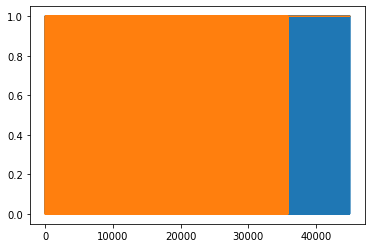

In [45]:
import matplotlib.pyplot as plt

plt.plot(pred)
plt.plot(y_val)

In [56]:
train_df['target'][-100:]

501851    1
501852    1
501853    1
501854    1
501855    1
         ..
501946    1
501947    1
501948    1
501949    1
501950    1
Name: target, Length: 100, dtype: int64

In [61]:
from sklearn import metrics

print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.66      0.48      0.56     22940
           1       0.58      0.75      0.65     22039

    accuracy                           0.61     44979
   macro avg       0.62      0.61      0.60     44979
weighted avg       0.62      0.61      0.60     44979



Precision : 모델이 True로 예측한 데이터 중 실제로 True인 데이터이 수

Recall : 실제 True인 데이터를 모델이 True라고 인식한 데이터의 수

F1 score는 precision 과 recall의 조화평균입니다.